In [2]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from salishsea_tools import viz_tools

%matplotlib inline

In [31]:
bathydata = xr.open_dataset('/home/sallen/MEOPAR/grid/bathymetry_201702.nc')
bathy = bathydata['Bathymetry']
meshdata = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc')
gdept_1d = meshdata['gdept_1d']
e3t_1d = meshdata['e3t_1d']
e3t_0 = meshdata['e3t_0'][0]
umask = meshdata['umask'][0]
vmask = meshdata['vmask'][0]
tmask = meshdata['tmask'][0]
realdepthdata = xr.open_dataset('/home/sallen/MEOPAR/grid/AfterNEMOBathy201702.nc')
realdepth = realdepthdata['Bathymetry']
print (realdepth.shape, e3t_0.shape)

g = 9.8

(898, 398) (40, 898, 398)


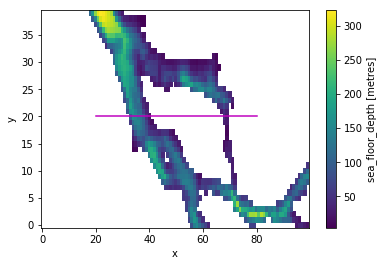

In [4]:
bathy[850:890, 30:130].plot()
plt.plot([50-30, 110-30], [870-850, 870-850], 'm-')

So along 870, from 50 to 110

In [5]:
iii = 870
jmin = 50
jmax = 110

121.86651840226745


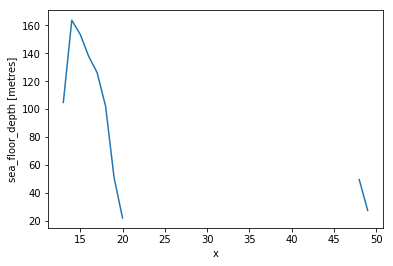

In [6]:
bathy[iii, jmin:jmax].plot()
print (gdept_1d.values[0, 27])

In [32]:
area = (e3t_0[:, iii, jmin:jmax] * 440 * tmask[:, iii, jmin:jmax]).sum()
area

<xarray.DataArray ()>
array(411545.855272)

In [7]:
kmax = 31

201812 2016 results are split across results/results2  
so use 201806 results in nowcast-green
NOPE no e3t so 2017 in results2

In [28]:
flux = np.zeros((kmax, jmax-jmin))

for directory in sorted(glob.glob('/results/SalishSea/hindcast.201812/?????16') +
                       glob.glob('/results2/SalishSea/hindcast.201812_annex/?????16')):
    vfile = directory + '/SalishSea_1h_*_grid_V.nc'
    efile = directory + '/SalishSea_1h_*_carp_T.nc'
    vel = glob.glob(vfile)[0]
    eee = glob.glob(efile)[0]
    print (vfile)
    with xr.open_dataset(vel)['vomecrty'] as vdata:
        with xr.open_dataset(eee)['e3t'] as edata:
            vvel = np.array(vdata[:, :kmax, iii, jmin:jmax])
            e3t = np.array(edata[:, :kmax, iii, jmin:jmax])
            e3tu = np.array(edata[:, :kmax, iii+1, jmin:jmax])
            for jj in range(jmax-jmin):
                for kk in range(kmax):
                    for tt in range(24):
                        e3v = min(e3t[tt, kk, jj], e3tu[tt, kk, jj])
                        flux[kk, jj] = flux[kk, jj] + (vvel[tt, kk, jj]*e3v)

/results/SalishSea/hindcast.201812/01apr16/SalishSea_1h_*_grid_V.nc
/results/SalishSea/hindcast.201812/01aug16/SalishSea_1h_*_grid_V.nc
/results/SalishSea/hindcast.201812/01feb16/SalishSea_1h_*_grid_V.nc
/results/SalishSea/hindcast.201812/01jan16/SalishSea_1h_*_grid_V.nc
/results/SalishSea/hindcast.201812/01jul16/SalishSea_1h_*_grid_V.nc
/results/SalishSea/hindcast.201812/01jun16/SalishSea_1h_*_grid_V.nc
/results/SalishSea/hindcast.201812/01mar16/SalishSea_1h_*_grid_V.nc
/results/SalishSea/hindcast.201812/01may16/SalishSea_1h_*_grid_V.nc
/results/SalishSea/hindcast.201812/01nov16/SalishSea_1h_*_grid_V.nc
/results/SalishSea/hindcast.201812/01oct16/SalishSea_1h_*_grid_V.nc
/results/SalishSea/hindcast.201812/01sep16/SalishSea_1h_*_grid_V.nc
/results/SalishSea/hindcast.201812/02apr16/SalishSea_1h_*_grid_V.nc
/results/SalishSea/hindcast.201812/02aug16/SalishSea_1h_*_grid_V.nc
/results/SalishSea/hindcast.201812/02feb16/SalishSea_1h_*_grid_V.nc
/results/SalishSea/hindcast.201812/02jan16/Salis

In [13]:
print (flux.shape, kmax)

(31, 60) 31


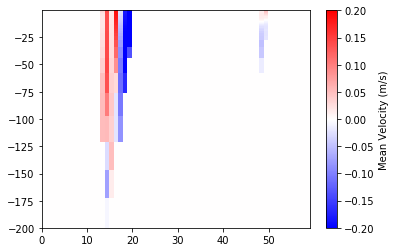

In [29]:
flux_forplot = np.empty_like(flux)
for j in range(jmax-jmin):
    flux_forplot[:kmax, j] = flux[:kmax, j]/(24*365)/e3t_1d[0, :kmax]
plt.pcolormesh(np.arange(60), -gdept_1d[0,:kmax], flux_forplot, cmap='bwr', vmax=0.2, vmin=-0.2 )
cb = plt.colorbar()
cb.set_label('Mean Velocity (m/s)')

-3047.332366377712
<xarray.DataArray ()>
array(-0.007405)
<xarray.DataArray ()>
array(-57.578168)  km in 90 days


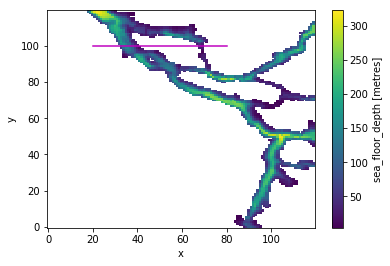

In [33]:
print (flux[:, 1:].sum()/24/365*440)
print (flux[:, 1:].sum()/24/365*440/area)
print (flux[:, 1:].sum()/24/365*440/area * 86400 * 90/ 1000, ' km in 90 days')
bathy[890-120:890, 30:150].plot()
plt.plot([50-30, 110-30], [870-890+120, 870-890+120], 'm-')

3300 m3/s south

In [178]:
bern = np.zeros((897, 397))

for directory in glob.glob('/results2/SalishSea/hindcast.201812_annex/??jan17'):
    uvile = directory + '/SalishSea_1h_*_grid_U.nc'
    vfile = directory + '/SalishSea_1h_*_grid_V.nc'
    efile = directory + '/SalishSea_1h_*_carp_T.nc'
    uel = glob.glob(uvile)[0]
    vel = glob.glob(vfile)[0]
    eee = glob.glob(efile)[0]
    print (vfile)
    with xr.open_dataset(uel)['vozocrtx'] as udata:
        with xr.open_dataset(vel)['vomecrty'] as vdata:
            with xr.open_dataset(eee)['e3t'] as edata:
                for tt in range(24):
                    uvel = np.array(np.array(udata[tt]) * umask)
                    vvel = np.array(np.array(vdata[tt]) * vmask)
                    e3t = np.array(edata[tt])
                    uu, vv = viz_tools.unstagger(uvel, vvel)
                    vuu = (uu* e3t[:, :-1, :-1]).sum(axis=0)/(
                        realdepth[:-1, :-1]+(1-tmask[0, :-1, :-1]))*tmask[0, :-1, :-1]
                    uvv = (vv * e3t[:, :-1, :-1]).sum(axis=0)/(
                        realdepth[:-1, :-1]+(1-tmask[0, :-1, :-1]))*tmask[0, :-1, :-1]
                    bern = bern + (vuu**2 + uvv**2)/(2*g)

/results2/SalishSea/hindcast.201812_annex/15jan17/SalishSea_1h_*_grid_V.nc
/results2/SalishSea/hindcast.201812_annex/30jan17/SalishSea_1h_*_grid_V.nc
/results2/SalishSea/hindcast.201812_annex/08jan17/SalishSea_1h_*_grid_V.nc
/results2/SalishSea/hindcast.201812_annex/10jan17/SalishSea_1h_*_grid_V.nc
/results2/SalishSea/hindcast.201812_annex/31jan17/SalishSea_1h_*_grid_V.nc
/results2/SalishSea/hindcast.201812_annex/09jan17/SalishSea_1h_*_grid_V.nc
/results2/SalishSea/hindcast.201812_annex/07jan17/SalishSea_1h_*_grid_V.nc
/results2/SalishSea/hindcast.201812_annex/16jan17/SalishSea_1h_*_grid_V.nc
/results2/SalishSea/hindcast.201812_annex/20jan17/SalishSea_1h_*_grid_V.nc
/results2/SalishSea/hindcast.201812_annex/01jan17/SalishSea_1h_*_grid_V.nc
/results2/SalishSea/hindcast.201812_annex/02jan17/SalishSea_1h_*_grid_V.nc
/results2/SalishSea/hindcast.201812_annex/23jan17/SalishSea_1h_*_grid_V.nc
/results2/SalishSea/hindcast.201812_annex/06jan17/SalishSea_1h_*_grid_V.nc
/results2/SalishSea/hindc

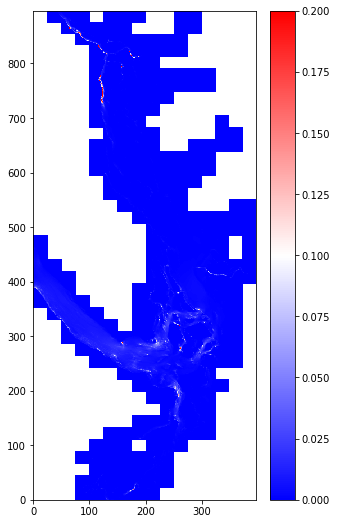

In [167]:
fig, ax = plt.subplots(1, 1, figsize=(5, 9))
colours = ax.pcolormesh(bern/24./9, cmap='bwr', vmax=0.2)
fig.colorbar(colours)

(40, 240)

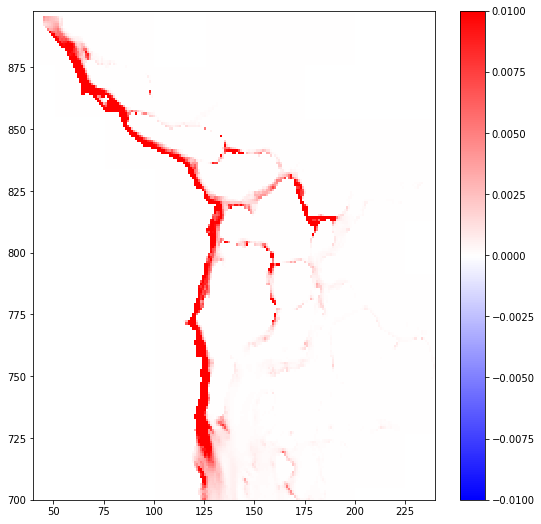

In [172]:
fig, ax = plt.subplots(1, 1, figsize=(9, 9))
colours = ax.pcolormesh(bern/24./9, cmap='bwr', vmax=0.01, vmin=-0.01)
fig.colorbar(colours)
ax.set_ylim(700, 898)
ax.set_xlim(40, 240)

In [177]:
print (bern[895, :].max()/24/9)

<xarray.DataArray ()>
array(0.004241)
Coordinates:
    y        int64 895
